In [4]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nengo
import nengo_spa
import sspspace
import time
from uniform_encoders import *

In [5]:
palette = sns.color_palette("dark")
sns.set_palette(palette)
sns.set(context='paper', style='white')

# Direct neurons, regression decoding

In [3]:
# Fix random seed
seed = 0
rng = np.random.RandomState(seed=seed)

ssp_dim = 16  # SSP dimension
grid_ls = 1  # lengthscale hypeparameters  - needs to be tuned
T = 1  # period of input cycle

# Initialize SSP space
loc_space = sspspace.RandomSSPSpace(ssp_dim=ssp_dim, domain_dim=2, rng=rng)
loc_space.update_lengthscale([grid_ls, grid_ls])

# dynamic input to the network
loc_input_func = lambda t: [np.sin(2*np.pi*t/T), np.cos(2*np.pi*t/T)]
ssp_encode_func = lambda x: loc_space.encode(x)

# nengo Network
network = nengo.Network(seed=seed)
with network:
    loc_input = nengo.Node(loc_input_func)
    loc_raw_node = nengo.Ensemble(n_neurons=1, dimensions=2, neuron_type=nengo.Direct())
    loc_ssp_node = nengo.Ensemble(n_neurons=1, dimensions=ssp_dim, neuron_type=nengo.Direct())
    
    nengo.Connection(loc_input, loc_raw_node, synapse=None)
    nengo.Connection(loc_raw_node, loc_ssp_node, synapse=None, function=ssp_encode_func)

    p_raw_node = nengo.Probe(loc_raw_node, synapse=None)
    p_ssp_node = nengo.Probe(loc_ssp_node, synapse=None)

In [4]:
sim = nengo.Simulator(network)
with sim:
    sim.run(2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [5]:
x_t = sim.data[p_ssp_node]
y_t = sim.data[p_raw_node]
y2_t = np.square(y_t[:,0])
W_T, residuals, rank, s = scipy.linalg.lstsq(x_t, y_t)
W2_T, residuals, rank, s = scipy.linalg.lstsq(x_t, y2_t)
W = W_T.T
W2 = W2_T.T
y_pred = (W @ x_t.T).T
y2_pred = (W2 @ x_t.T).T

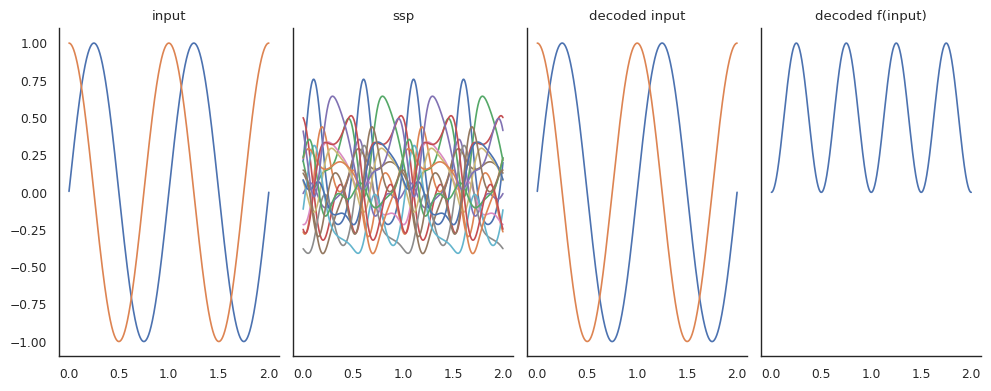

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(10,4))
axes[0].plot(sim.trange(), sim.data[p_raw_node])
axes[1].plot(sim.trange(), sim.data[p_ssp_node])
axes[2].plot(sim.trange(), y_pred)
axes[3].plot(sim.trange(), y2_pred)
axes[0].set(title='input')
axes[1].set(title='ssp')
axes[2].set(title='decoded input')
axes[3].set(title='decoded f(input)')
sns.despine()
plt.tight_layout()

# LIF neurons, regression decoding

In [7]:
# Fix random seed
seed = 0
rng = np.random.RandomState(seed=seed)

ssp_dim = 16  # SSP dimension
grid_ls = 1  # lengthscale hypeparameters  - needs to be tuned
T = 1  # period of input cycle

# Initialize SSP space
loc_space = sspspace.RandomSSPSpace(ssp_dim=ssp_dim, domain_dim=2, rng=rng)
loc_space.update_lengthscale([grid_ls, grid_ls])

# dynamic input to the network
loc_input_func = lambda t: [np.sin(2*np.pi*t/T), np.cos(2*np.pi*t/T)]
ssp_encode_func = lambda x: loc_space.encode(x)

# nengo Network
network = nengo.Network(seed=seed)
with network:
    loc_input = nengo.Node(loc_input_func)
    loc_raw_node = nengo.Ensemble(n_neurons=1, dimensions=2, neuron_type=nengo.Direct())
    loc_ssp_node = nengo.Ensemble(n_neurons=1, dimensions=ssp_dim, neuron_type=nengo.Direct())
    loc_ssp = nengo.Ensemble(n_neurons=2000, dimensions=ssp_dim)
    
    nengo.Connection(loc_input, loc_raw_node, synapse=None)
    nengo.Connection(loc_raw_node, loc_ssp_node, synapse=None, function=ssp_encode_func)
    nengo.Connection(loc_ssp_node, loc_ssp, synapse=None)

    p_raw_node = nengo.Probe(loc_raw_node, synapse=None)
    p_ssp_node = nengo.Probe(loc_ssp_node, synapse=None)
    p_ssp = nengo.Probe(loc_ssp, synapse=0.01)
    p_ssp_neurons = nengo.Probe(loc_ssp.neurons, synapse=0.01)

In [8]:
sim = nengo.Simulator(network)
with sim:
    sim.run(2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [9]:
x_t = sim.data[p_ssp]
a_t = sim.data[p_ssp]
y_t = sim.data[p_raw_node]
W_T, residuals, rank, s = scipy.linalg.lstsq(x_t, y_t)
Wa_T, residuals, rank, s = scipy.linalg.lstsq(a_t, y_t)
W = W_T.T
Wa = Wa_T.T
y_pred = (W @ x_t.T).T
ya_pred = (Wa @ a_t.T).T

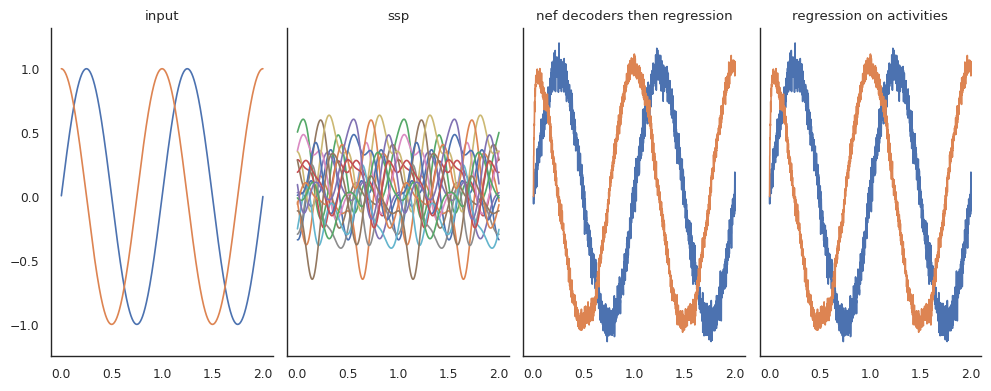

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(10,4))
axes[0].plot(sim.trange(), sim.data[p_raw_node])
axes[1].plot(sim.trange(), sim.data[p_ssp_node])
axes[2].plot(sim.trange(), y_pred)
axes[3].plot(sim.trange(), ya_pred)
axes[0].set(title='input')
axes[1].set(title='ssp')
axes[2].set(title='nef decoders then regression')
axes[3].set(title='regression on activities')
sns.despine()
plt.tight_layout()

# uniform encoders

In [121]:
# Fix random seed
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

ssp_dim = 16  # SSP dimension
grid_ls = 1  # lengthscale hypeparameters  - needs to be tuned
T = 1  # period of input cycle

# Initialize SSP space
loc_space = sspspace.RandomSSPSpace(ssp_dim=ssp_dim, domain_dim=2, rng=rng)
loc_space.update_lengthscale([grid_ls, grid_ls])

# dynamic input to the network
loc_input_func = lambda t: [np.sin(2*np.pi*t/T), np.cos(2*np.pi*t/T)]
ssp_encode_func = lambda x: loc_space.encode(x)

# neural parameters for SSP population
ssp_neurons = 1000
ssp_intercept = 0.2
ssp_encoders = ScatteredHypersphere(surface=True).sample(ssp_neurons, ssp_dim, rng=rng)
ssp_intercepts = nengo.dists.Uniform(ssp_intercept, ssp_intercept)

# nengo Network
network = nengo.Network(seed=seed)
with network:
    loc_input = nengo.Node(loc_input_func)
    loc_raw_node = nengo.Ensemble(n_neurons=1, dimensions=2, neuron_type=nengo.Direct())
    loc_ssp_node = nengo.Ensemble(n_neurons=1, dimensions=ssp_dim, neuron_type=nengo.Direct())
    loc_ssp = nengo.Ensemble(n_neurons=ssp_neurons, dimensions=ssp_dim, seed=seed,
                            encoders=ssp_encoders, intercepts=ssp_intercepts)
    
    nengo.Connection(loc_input, loc_raw_node, synapse=None)
    nengo.Connection(loc_raw_node, loc_ssp_node, synapse=None, function=ssp_encode_func)
    nengo.Connection(loc_ssp_node, loc_ssp, synapse=None)

    p_raw_node = nengo.Probe(loc_raw_node, synapse=None)
    p_ssp_node = nengo.Probe(loc_ssp_node, synapse=None)
    p_ssp = nengo.Probe(loc_ssp, synapse=0.01)
    p_ssp_neurons = nengo.Probe(loc_ssp.neurons, synapse=0.01)

In [122]:
sim = nengo.Simulator(network)
with sim:
    sim.run(2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [123]:
x_t = sim.data[p_ssp]
a_t = sim.data[p_ssp]
y_t = sim.data[p_raw_node]
W_T, residuals, rank, s = scipy.linalg.lstsq(x_t, y_t)
Wa_T, residuals, rank, s = scipy.linalg.lstsq(a_t, y_t)
W = W_T.T
Wa = Wa_T.T
y_pred = (W @ x_t.T).T
ya_pred = (Wa @ a_t.T).T

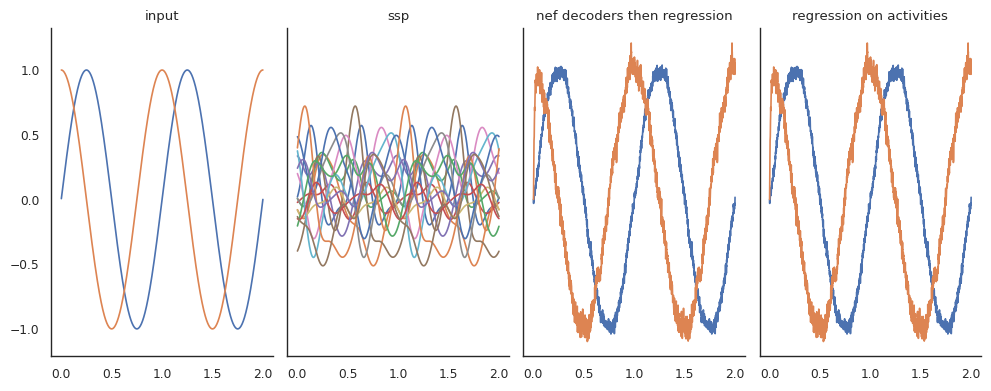

In [124]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(10,4))
axes[0].plot(sim.trange(), sim.data[p_raw_node])
axes[1].plot(sim.trange(), sim.data[p_ssp_node])
axes[2].plot(sim.trange(), y_pred)
axes[3].plot(sim.trange(), ya_pred)
axes[0].set(title='input')
axes[1].set(title='ssp')
axes[2].set(title='nef decoders then regression')
axes[3].set(title='regression on activities')
sns.despine()
plt.tight_layout()

# online learning to decode

In [160]:
# Fix random seed
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

ssp_dim = 16  # SSP dimension
grid_ls = 1  # lengthscale hypeparameters  - needs to be tuned
P = 1  # period of input cycle
T = 20*P
E = 15*P

# Initialize SSP space
loc_space = sspspace.RandomSSPSpace(ssp_dim=ssp_dim, domain_dim=2, rng=rng)
loc_space.update_lengthscale([grid_ls, grid_ls])

# dynamic input to the network
loc_input_func = lambda t: [np.sin(2*np.pi*t/T), np.cos(2*np.pi*t/T)]
ssp_encode_func = lambda x: loc_space.encode(x)

# neural parameters for SSP population
ssp_neurons = 1000
ssp_intercept = 0.3
ssp_encoders = ScatteredHypersphere(surface=True).sample(ssp_neurons, ssp_dim, rng=rng)
ssp_intercepts = nengo.dists.Uniform(ssp_intercept, ssp_intercept)
error_neurons = 1000

# dynamic input to the network
loc_input_func = lambda t: [np.sin(2*np.pi*t/P), np.cos(2*np.pi*t/P)]
ssp_encode_func = lambda x: loc_space.encode(x)

# computed function
target_func = lambda x: x
null_func = lambda x: [0,0]

# error-driven learning rule
pes = nengo.PES(learning_rate=3e-3)

# nengo Network
network = nengo.Network(seed=seed)
with network:
    loc_input = nengo.Node(loc_input_func)
    loc_raw_node = nengo.Ensemble(n_neurons=1, dimensions=2, neuron_type=nengo.Direct())
    loc_ssp_node = nengo.Ensemble(n_neurons=1, dimensions=ssp_dim, neuron_type=nengo.Direct())
    loc_ssp = nengo.Ensemble(n_neurons=ssp_neurons, dimensions=ssp_dim, seed=seed,
                            encoders=ssp_encoders, intercepts=ssp_intercepts)
    output = nengo.Ensemble(1, dimensions=2, neuron_type=nengo.Direct())
    target = nengo.Ensemble(1, dimensions=2, neuron_type=nengo.Direct())
    error = nengo.Ensemble(n_neurons=error_neurons, dimensions=2)
    stop = nengo.Node(lambda t: -1000 if t>E else 0)
    
    nengo.Connection(loc_input, loc_raw_node, synapse=None)
    nengo.Connection(loc_raw_node, loc_ssp_node, synapse=None, function=ssp_encode_func)
    nengo.Connection(loc_raw_node, target, synapse=0.01, function=target_func)
    nengo.Connection(loc_ssp_node, loc_ssp, synapse=None)
    a = nengo.Connection(loc_ssp, output, synapse=0.01, function=null_func, learning_rule_type=pes)
    nengo.Connection(output, error, synapse=0.01, transform=-1)
    nengo.Connection(target, error, synapse=0.01, transform=1)
    nengo.Connection(error, a.learning_rule, synapse=0.01, transform=-1)
    nengo.Connection(stop, error.neurons, transform=np.ones((error_neurons, 1)), synapse=None)

    p_raw_node = nengo.Probe(loc_raw_node, synapse=None)
    p_ssp_node = nengo.Probe(loc_ssp_node, synapse=None)
    p_ssp = nengo.Probe(loc_ssp, synapse=0.01)
    p_output = nengo.Probe(output, synapse=0.01)
    p_error = nengo.Probe(error, synapse=0.01)

In [161]:
sim = nengo.Simulator(network, progress_bar=False)
with sim:
    sim.run(T)

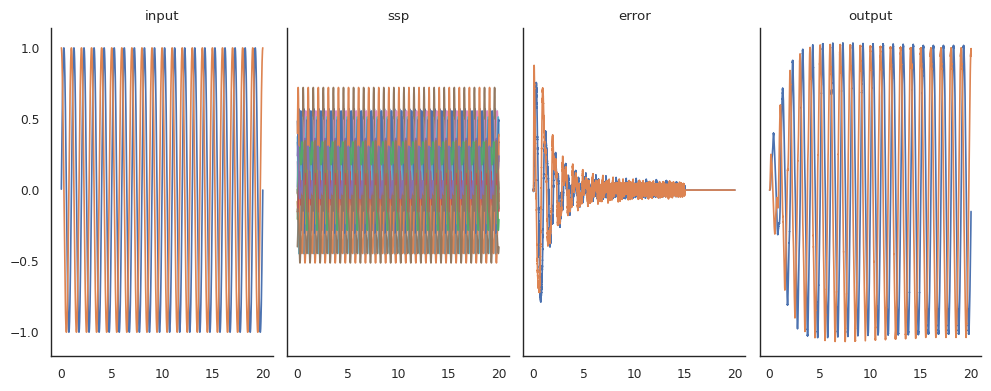

In [162]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(10,4))
axes[0].plot(sim.trange(), sim.data[p_raw_node])
axes[1].plot(sim.trange(), sim.data[p_ssp_node])
axes[2].plot(sim.trange(), sim.data[p_error])
axes[3].plot(sim.trange(), sim.data[p_output])
axes[0].set(title='input')
axes[1].set(title='ssp')
axes[2].set(title='error')
axes[3].set(title='output')
sns.despine()
plt.tight_layout()

# decode a reward function

In [195]:
# Fix random seed
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

ssp_dim = 16  # SSP dimension
grid_ls = 1  # lengthscale hypeparameters  - needs to be tuned
P = 1  # period of input cycle
T = 12*P
E = 10*P

# Initialize SSP space
loc_space = sspspace.RandomSSPSpace(ssp_dim=ssp_dim, domain_dim=2, rng=rng)
loc_space.update_lengthscale([grid_ls, grid_ls])

# dynamic input to the network
loc_input_func = lambda t: [np.sin(2*np.pi*t/T), np.cos(2*np.pi*t/T)]
ssp_encode_func = lambda x: loc_space.encode(x)

# neural parameters for SSP population
ssp_neurons = 1000
ssp_intercept = 0.3
ssp_encoders = ScatteredHypersphere(surface=True).sample(ssp_neurons, ssp_dim, rng=rng)
ssp_intercepts = nengo.dists.Uniform(ssp_intercept, ssp_intercept)
error_neurons = 1000

# dynamic input to the network
loc_input_func = lambda t: [np.sin(2*np.pi*t/P), np.cos(2*np.pi*t/P)]
ssp_encode_func = lambda x: loc_space.encode(x)
# target_func = lambda x: x[0] + x[1]
target_func = lambda x: np.arctan2(x[1], x[0]) / np.pi

# error-driven learning rule
pes = nengo.PES(learning_rate=3e-3)

# nengo Network
network = nengo.Network(seed=seed)
with network:
    loc_input = nengo.Node(loc_input_func)
    loc_raw_node = nengo.Ensemble(n_neurons=1, dimensions=2, neuron_type=nengo.Direct())
    loc_ssp_node = nengo.Ensemble(n_neurons=1, dimensions=ssp_dim, neuron_type=nengo.Direct())
    loc_ssp = nengo.Ensemble(n_neurons=ssp_neurons, dimensions=ssp_dim, seed=seed,
                            encoders=ssp_encoders, intercepts=ssp_intercepts)
    output = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    target = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    error = nengo.Ensemble(n_neurons=error_neurons, dimensions=1)
    stop = nengo.Node(lambda t: -1000 if t>E else 0)
    
    nengo.Connection(loc_input, loc_raw_node, synapse=None)
    nengo.Connection(loc_raw_node, loc_ssp_node, synapse=None, function=ssp_encode_func)
    nengo.Connection(loc_raw_node, target, synapse=0.01, function=target_func)
    nengo.Connection(loc_ssp_node, loc_ssp, synapse=None)
    a = nengo.Connection(loc_ssp, output, synapse=0.01, function=lambda x: 0, learning_rule_type=pes)
    nengo.Connection(output, error, synapse=0.01, transform=-1)
    nengo.Connection(target, error, synapse=0.01, transform=1)
    nengo.Connection(error, a.learning_rule, synapse=0.01, transform=-1)
    nengo.Connection(stop, error.neurons, transform=np.ones((error_neurons, 1)), synapse=None)

    p_raw_node = nengo.Probe(loc_raw_node, synapse=None)
    p_ssp_node = nengo.Probe(loc_ssp_node, synapse=None)
    p_ssp = nengo.Probe(loc_ssp, synapse=0.01)
    p_output = nengo.Probe(output, synapse=0.01)
    p_target = nengo.Probe(target, synapse=0.01)
    p_error = nengo.Probe(error, synapse=0.01)

In [196]:
sim = nengo.Simulator(network, progress_bar=False)
with sim:
    sim.run(T)

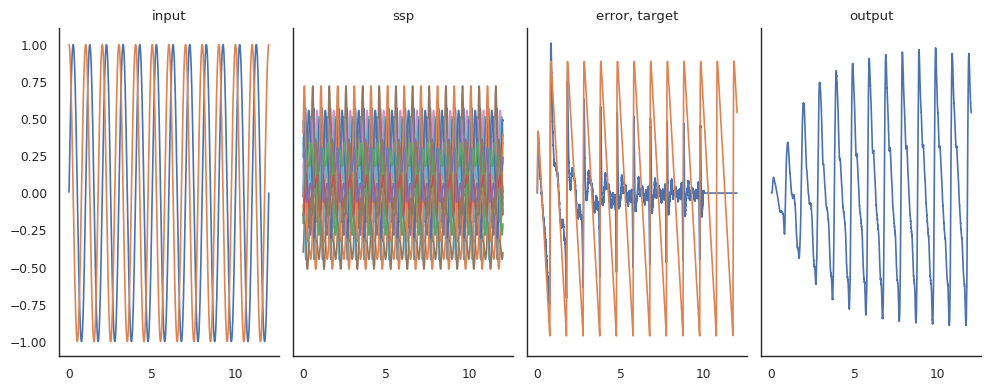

In [197]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(10,4))
axes[0].plot(sim.trange(), sim.data[p_raw_node])
axes[1].plot(sim.trange(), sim.data[p_ssp_node])
axes[2].plot(sim.trange(), sim.data[p_error])
axes[2].plot(sim.trange(), sim.data[p_target])
axes[3].plot(sim.trange(), sim.data[p_output])
axes[0].set(title='input')
axes[1].set(title='ssp')
axes[2].set(title='error, target')
axes[3].set(title='output')
sns.despine()
plt.tight_layout()

# 3 features, block presentation, linear reward function

In [525]:
# Fix random seed
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

P = 1  # trial time
T = 200*P  # total time
E = 150*P  # training time

ssp_dim = 64  # SSP dimension
length_scale = 10  # lengthscale hypeparameter
ssp_intercept = 0.2
ssp_neurons = 5000
error_neurons = 500
learning_rate = 5e-3

# Initialize SSP space
ssp_space = sspspace.RandomSSPSpace(ssp_dim=ssp_dim, domain_dim=3, rng=rng)
ssp_space.update_lengthscale([length_scale, length_scale, length_scale])

# dynamic input to the network
value_func = lambda x: x[0] + 0.5*x[1] - 0.5*x[2]
objects = []
values = []
for trial in range(int(T/P)):
    features = rng.uniform(-1,1,size=3)
    object_ssp = ssp_space.encode(features)
    objects.append(object_ssp)
    value = value_func(features)
    values.append(value)

# dynamic input to the network
input_func = lambda t: objects[int(t/P)].flatten()
target_func = lambda t: values[int(t/P)].flatten()

# encoders and intercepts determine tuning curve distribution
ssp_encoders = ScatteredHypersphere(surface=True).sample(ssp_neurons, ssp_dim, rng=rng)
ssp_intercepts = nengo.dists.Uniform(ssp_intercept, ssp_intercept)

# error-driven learning rule
pes = nengo.PES(learning_rate=learning_rate)

# nengo Network
network = nengo.Network(seed=seed)
with network:
    inpt_ssp = nengo.Node(input_func)
    inpt_target = nengo.Node(target_func)
    state = nengo.Ensemble(n_neurons=ssp_neurons, dimensions=ssp_dim, seed=seed,
                            encoders=ssp_encoders, intercepts=ssp_intercepts)
    output = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    target = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    error = nengo.Ensemble(n_neurons=error_neurons, dimensions=1)
    temp = nengo.Ensemble(1, dimensions=2, neuron_type=nengo.Direct())
    reward = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    stop = nengo.Node(lambda t: -1000 if t>E else 0)
    
    nengo.Connection(inpt_ssp, state, synapse=None)
    nengo.Connection(inpt_target, target, synapse=0.01)
    a = nengo.Connection(state, output, synapse=0.01, function=lambda x: 0, learning_rule_type=pes)
    nengo.Connection(output, error, synapse=None, transform=-1)
    nengo.Connection(target, error, synapse=None, transform=1)
    nengo.Connection(error, a.learning_rule, synapse=None, transform=-1)
    nengo.Connection(stop, error.neurons, transform=np.ones((error_neurons, 1)), synapse=None)
    nengo.Connection(output, temp[0], synapse=None)
    nengo.Connection(target, temp[1], synapse=None)
    nengo.Connection(temp, reward, synapse=None, function=lambda x: np.abs(x[0]-x[1]))

    p_state = nengo.Probe(state, synapse=0.01)
    p_output = nengo.Probe(output, synapse=0.01)
    p_target = nengo.Probe(target, synapse=0.01)
    p_error = nengo.Probe(error, synapse=0.01)
    p_reward = nengo.Probe(reward, synapse=0.01)

In [526]:
sim = nengo.Simulator(network, progress_bar=False)
with sim:
    sim.run(T-0.001)

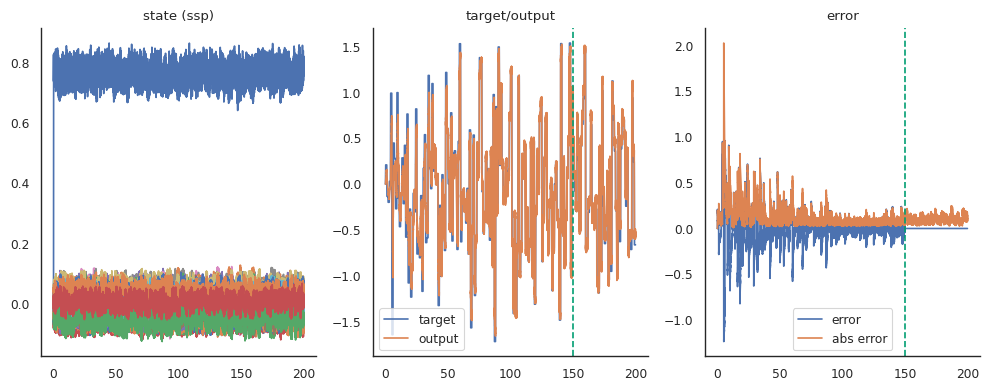

In [527]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(10,4))
axes[0].plot(sim.trange(), sim.data[p_state])
axes[1].plot(sim.trange(), sim.data[p_target], label='target')
axes[1].plot(sim.trange(), sim.data[p_output], label='output')
axes[2].plot(sim.trange(), sim.data[p_error], label='error')
axes[2].plot(sim.trange(), sim.data[p_reward], label='abs error')
axes[1].axvline(E, color=palette[2], linestyle='--')
axes[2].axvline(E, color=palette[2], linestyle='--')
axes[0].set(title='state (ssp)')
axes[1].set(title='target/output')
axes[2].set(title='error')
axes[1].legend()
axes[2].legend()
sns.despine()
plt.tight_layout()

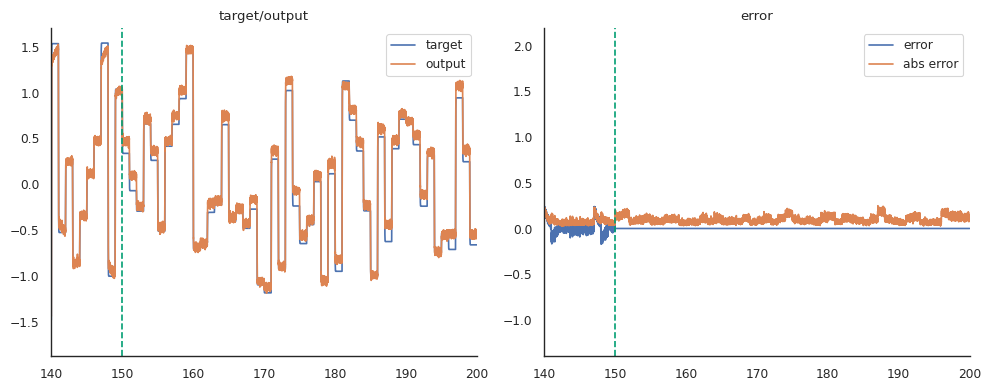

In [528]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(10,4))
axes[0].plot(sim.trange(), sim.data[p_target], label='target')
axes[0].plot(sim.trange(), sim.data[p_output], label='output')
axes[1].plot(sim.trange(), sim.data[p_error], label='error')
axes[1].plot(sim.trange(), sim.data[p_reward], label='abs error')
axes[0].axvline(E, color=palette[2], linestyle='--')
axes[1].axvline(E, color=palette[2], linestyle='--')
axes[0].set(title='target/output', xlim=[E-10*P,T])
axes[1].set(title='error', xlim=[E-10*P,T])
axes[0].legend()
axes[1].legend()
sns.despine()
plt.tight_layout()

# Noisy feedback

In [667]:
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

P = 1  # trial time
T = 600*P  # total time
E = 500*P  # training time

ssp_dim = 64  # SSP dimension
length_scale = 10  # lengthscale hypeparameter
ssp_intercept = 0.0
ssp_neurons = 3000
error_neurons = 300
learning_rate = 2e-4
sigma_target = 1e-1

# Initialize SSP space
ssp_space = sspspace.RandomSSPSpace(ssp_dim=ssp_dim, domain_dim=3, rng=rng)
ssp_space.update_lengthscale([length_scale, length_scale, length_scale])

# dynamic input to the network
value_func = lambda x: x[0] + 0.5*x[1] - 0.5*x[2]
objects = []
values = []
noises = []
for trial in range(int(T/P)):
    features = rng.uniform(-1,1,size=3)
    object_ssp = ssp_space.encode(features)
    objects.append(object_ssp)
    value = value_func(features)
    values.append(value)
    noise = rng.normal(0, sigma_target)
    noises.append(noise if trial < E/P else 0)  # remove noise during testing:
    

# dynamic input to the network
input_func = lambda t: objects[int(t/P)].flatten()
target_func = lambda t: values[int(t/P)].flatten() + noises[int(t/P)]

# encoders and intercepts determine tuning curve distribution
ssp_encoders = ScatteredHypersphere(surface=True).sample(ssp_neurons, ssp_dim, rng=rng)
ssp_intercepts = nengo.dists.Uniform(ssp_intercept, ssp_intercept)

# error-driven learning rule
pes = nengo.PES(learning_rate=learning_rate)

# nengo Network
network = nengo.Network(seed=seed)
with network:
    inpt_ssp = nengo.Node(input_func)
    inpt_target = nengo.Node(target_func)
    state = nengo.Ensemble(n_neurons=ssp_neurons, dimensions=ssp_dim, seed=seed,
                            encoders=ssp_encoders, intercepts=ssp_intercepts)
    output = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    target = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    error = nengo.Ensemble(n_neurons=error_neurons, dimensions=1)
    temp = nengo.Ensemble(1, dimensions=2, neuron_type=nengo.Direct())
    reward = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    stop = nengo.Node(lambda t: -1000 if t>E else 0)
    
    nengo.Connection(inpt_ssp, state, synapse=None)
    nengo.Connection(inpt_target, target, synapse=0.01)
    a = nengo.Connection(state, output, synapse=0.01, function=lambda x: 0, learning_rule_type=pes)
    nengo.Connection(output, error, synapse=None, transform=-1)
    nengo.Connection(target, error, synapse=None, transform=1)
    nengo.Connection(error, a.learning_rule, synapse=None, transform=-1)
    nengo.Connection(stop, error.neurons, transform=np.ones((error_neurons, 1)), synapse=None)
    nengo.Connection(output, temp[0], synapse=None)
    nengo.Connection(target, temp[1], synapse=None)
    nengo.Connection(temp, reward, synapse=None, function=lambda x: np.abs(x[0]-x[1]))

    p_ssp = nengo.Probe(inpt_ssp, synapse=0.01)
    p_state = nengo.Probe(state, synapse=0.01)
    p_output = nengo.Probe(output, synapse=0.01)
    p_target = nengo.Probe(target, synapse=0.01)
    p_error = nengo.Probe(error, synapse=0.01)
    p_reward = nengo.Probe(reward, synapse=0.01)

sim = nengo.Simulator(network, progress_bar=False)
with sim:
    sim.run(T-0.001)

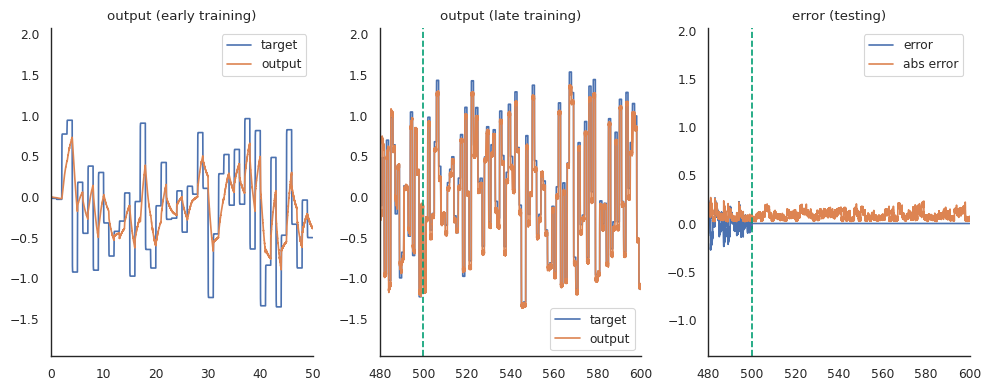

In [668]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(10,4))
axes[0].plot(sim.trange(), sim.data[p_target], label='target')
axes[0].plot(sim.trange(), sim.data[p_output], label='output')
axes[1].plot(sim.trange(), sim.data[p_target], label='target')
axes[1].plot(sim.trange(), sim.data[p_output], label='output')
axes[2].plot(sim.trange(), sim.data[p_error], label='error')
axes[2].plot(sim.trange(), sim.data[p_reward], label='abs error')
axes[1].axvline(E, color=palette[2], linestyle='--')
axes[2].axvline(E, color=palette[2], linestyle='--')
axes[0].set(title='output (early training)', xlim=[0, 50*P])
axes[1].set(title='output (late training)', xlim=[E-20*P,T])
axes[2].set(title='error (testing)', xlim=[E-20*P,T])
axes[0].legend()
axes[1].legend()
axes[2].legend()
sns.despine()
plt.tight_layout()

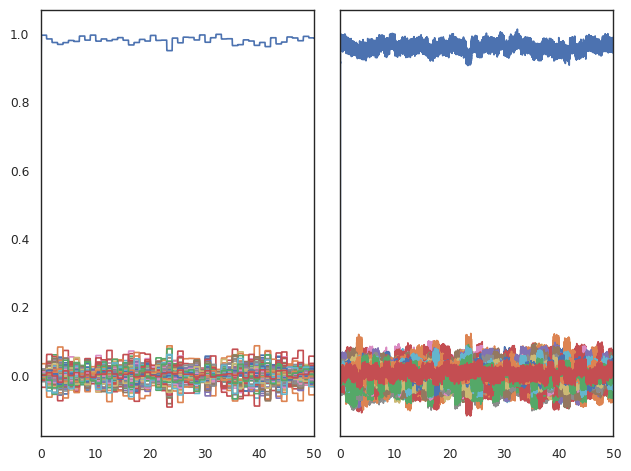

In [669]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
axes[0].plot(sim.trange(), sim.data[p_ssp])
axes[1].plot(sim.trange(), sim.data[p_state])
axes[0].set(xlim=[0,50*P])
plt.tight_layout()

# Try with SPA parameters instead of uniform_hypersphere

In [702]:
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

P = 1  # trial time
T = 600*P  # total time
E = 500*P  # training time

ssp_dim = 64  # SSP dimension
length_scale = 10  # lengthscale hypeparameter
ssp_intercept = 0.0
ssp_neurons = 3000
error_neurons = 300
learning_rate = 2e-4
sigma_target = 1e-1

# Initialize SSP space
ssp_space = sspspace.RandomSSPSpace(ssp_dim=ssp_dim, domain_dim=3, rng=rng)
ssp_space.update_lengthscale([length_scale, length_scale, length_scale])

# dynamic input to the network
value_func = lambda x: x[0] + 0.5*x[1] - 0.5*x[2]
objects = []
values = []
noises = []
for trial in range(int(T/P)):
    features = rng.uniform(-1,1,size=3)
    object_ssp = ssp_space.encode(features)
    objects.append(object_ssp)
    value = value_func(features)
    values.append(value)
    noise = rng.normal(0, sigma_target)
    noises.append(noise if trial < E/P else 0)  # remove noise during testing:
    

# dynamic input to the network
input_func = lambda t: objects[int(t/P)].flatten()
target_func = lambda t: values[int(t/P)].flatten() + noises[int(t/P)]

# error-driven learning rule
pes = nengo.PES(learning_rate=learning_rate)

# nengo Network
network = nengo.Network(seed=seed)
with network:
    inpt_ssp = nengo.Node(input_func)
    inpt_target = nengo.Node(target_func)
    state = nengo.Ensemble(n_neurons=ssp_neurons, dimensions=ssp_dim, seed=seed,
        eval_points=nengo.dists.CosineSimilarity(ssp_dim + 2),
        intercepts=nengo.dists.CosineSimilarity(ssp_dim + 2),)
    output = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    target = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    error = nengo.Ensemble(n_neurons=error_neurons, dimensions=1)
    temp = nengo.Ensemble(1, dimensions=2, neuron_type=nengo.Direct())
    reward = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    stop = nengo.Node(lambda t: -1000 if t>E else 0)
    
    nengo.Connection(inpt_ssp, state, synapse=None)
    nengo.Connection(inpt_target, target, synapse=0.01)
    a = nengo.Connection(state, output, synapse=0.01, function=lambda x: 0, learning_rule_type=pes)
    nengo.Connection(output, error, synapse=None, transform=-1)
    nengo.Connection(target, error, synapse=None, transform=1)
    nengo.Connection(error, a.learning_rule, synapse=None, transform=-1)
    nengo.Connection(stop, error.neurons, transform=np.ones((error_neurons, 1)), synapse=None)
    nengo.Connection(output, temp[0], synapse=None)
    nengo.Connection(target, temp[1], synapse=None)
    nengo.Connection(temp, reward, synapse=None, function=lambda x: np.abs(x[0]-x[1]))

    p_ssp = nengo.Probe(inpt_ssp, synapse=0.01)
    p_state = nengo.Probe(state, synapse=0.01)
    p_output = nengo.Probe(output, synapse=0.01)
    p_target = nengo.Probe(target, synapse=0.01)
    p_error = nengo.Probe(error, synapse=0.01)
    p_reward = nengo.Probe(reward, synapse=0.01)

sim = nengo.Simulator(network, progress_bar=False)
with sim:
    sim.run(T-0.001)

In [703]:
sim = nengo.Simulator(network, progress_bar=False)
with sim:
    sim.run(T-0.001)

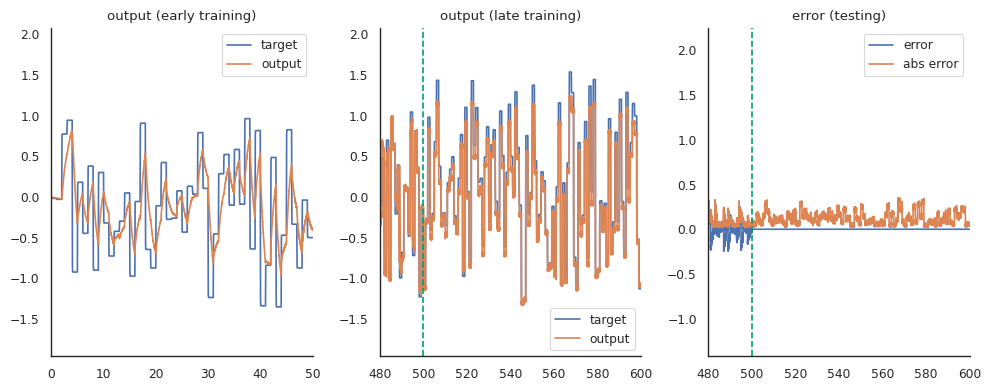

In [704]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(10,4))
axes[0].plot(sim.trange(), sim.data[p_target], label='target')
axes[0].plot(sim.trange(), sim.data[p_output], label='output')
axes[1].plot(sim.trange(), sim.data[p_target], label='target')
axes[1].plot(sim.trange(), sim.data[p_output], label='output')
axes[2].plot(sim.trange(), sim.data[p_error], label='error')
axes[2].plot(sim.trange(), sim.data[p_reward], label='abs error')
axes[1].axvline(E, color=palette[2], linestyle='--')
axes[2].axvline(E, color=palette[2], linestyle='--')
axes[0].set(title='output (early training)', xlim=[0, 50*P])
axes[1].set(title='output (late training)', xlim=[E-20*P,T])
axes[2].set(title='error (testing)', xlim=[E-20*P,T])
axes[0].legend()
axes[1].legend()
axes[2].legend()
sns.despine()
plt.tight_layout()

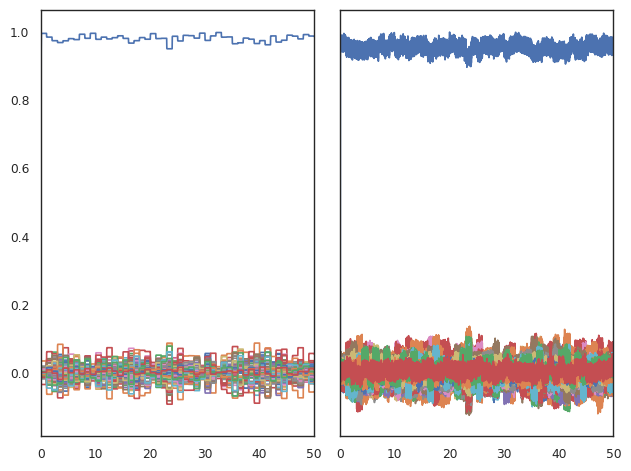

In [705]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
axes[0].plot(sim.trange(), sim.data[p_ssp])
axes[1].plot(sim.trange(), sim.data[p_state])
axes[0].set(xlim=[0,50*P])
plt.tight_layout()

# Try with actual SPA network

In [717]:
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

P = 1  # trial time
T = 400*P  # total time
E = 300*P  # training time

ssp_dim = 64  # SSP dimension
length_scale = 10  # lengthscale hypeparameter
ssp_neurons = 3000
error_neurons = 300
learning_rate = 5e-5
sigma_target = 1e-1

# Initialize SSP space
ssp_space = sspspace.RandomSSPSpace(ssp_dim=ssp_dim, domain_dim=3, rng=rng)
ssp_space.update_lengthscale([length_scale, length_scale, length_scale])

# dynamic input to the network
value_func = lambda x: x[0] + 0.5*x[1] - 0.5*x[2]
objects = []
values = []
noises = []
for trial in range(int(T/P)):
    features = rng.uniform(-1,1,size=3)
    object_ssp = ssp_space.encode(features)
    objects.append(object_ssp)
    value = value_func(features)
    values.append(value)
    noise = rng.normal(0, sigma_target)
    noises.append(noise if trial < E/P else 0)  # remove noise during testing:
    

# dynamic input to the network
input_func = lambda t: objects[int(t/P)].flatten()
target_func = lambda t: values[int(t/P)].flatten() + noises[int(t/P)]

# error-driven learning rule
pes = nengo.PES(learning_rate=learning_rate)

# nengo Network
network = nengo_spa.Network(seed=seed)
with network:
    inpt_ssp = nengo.Node(input_func)
    inpt_target = nengo.Node(target_func)
    state = nengo_spa.State(ssp_dim, subdimensions=4, neurons_per_dimension=200, represent_cc_identity=False)
    output = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    target = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    error = nengo.Ensemble(n_neurons=error_neurons, dimensions=1)
    temp = nengo.Ensemble(1, dimensions=2, neuron_type=nengo.Direct())
    reward = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    stop = nengo.Node(lambda t: -1000 if t>E else 0)
    
    # nengo.Connection(inpt_ssp, state, synapse=None)
    nengo.Connection(inpt_ssp, state.input, synapse=None)
    nengo.Connection(inpt_target, target, synapse=0.01)
    learning_conns = []
    for ens in state.state_ensembles.ea_ensembles:
        learning_conns.append(nengo.Connection(ens, output, synapse=0.01, function=lambda x: 0, learning_rule_type=pes))
    nengo.Connection(output, error, synapse=None, transform=-1)
    nengo.Connection(target, error, synapse=None, transform=1)
    for ens in learning_conns:
        nengo.Connection(error, ens.learning_rule, synapse=None, transform=-1)
    nengo.Connection(stop, error.neurons, transform=np.ones((error_neurons, 1)), synapse=None)
    nengo.Connection(output, temp[0], synapse=None)
    nengo.Connection(target, temp[1], synapse=None)
    nengo.Connection(temp, reward, synapse=None, function=lambda x: np.abs(x[0]-x[1]))

    p_ssp = nengo.Probe(inpt_ssp, synapse=0.01)
    p_state = nengo.Probe(state.output, synapse=0.01)
    p_output = nengo.Probe(output, synapse=0.01)
    p_target = nengo.Probe(target, synapse=0.01)
    p_error = nengo.Probe(error, synapse=0.01)
    p_reward = nengo.Probe(reward, synapse=0.01)

sim = nengo.Simulator(network, progress_bar=False)
with sim:
    sim.run(T-0.001)

sim = nengo.Simulator(network, progress_bar=False)
with sim:
    sim.run(T-0.001)

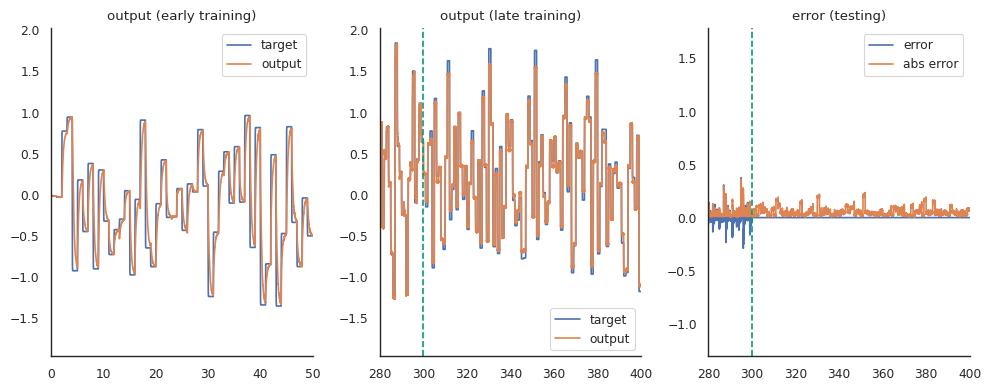

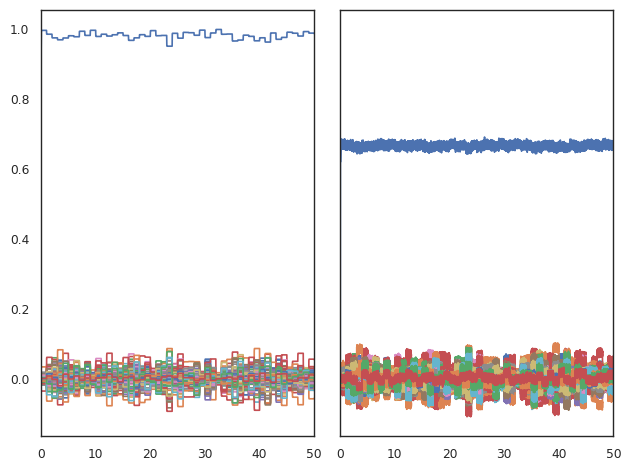

In [718]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(10,4))
axes[0].plot(sim.trange(), sim.data[p_target], label='target')
axes[0].plot(sim.trange(), sim.data[p_output], label='output')
axes[1].plot(sim.trange(), sim.data[p_target], label='target')
axes[1].plot(sim.trange(), sim.data[p_output], label='output')
axes[2].plot(sim.trange(), sim.data[p_error], label='error')
axes[2].plot(sim.trange(), sim.data[p_reward], label='abs error')
axes[1].axvline(E, color=palette[2], linestyle='--')
axes[2].axvline(E, color=palette[2], linestyle='--')
axes[0].set(title='output (early training)', xlim=[0, 50*P])
axes[1].set(title='output (late training)', xlim=[E-20*P,T])
axes[2].set(title='error (testing)', xlim=[E-20*P,T])
axes[0].legend()
axes[1].legend()
axes[2].legend()
sns.despine()
plt.tight_layout()

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
axes[0].plot(sim.trange(), sim.data[p_ssp])
axes[1].plot(sim.trange(), sim.data[p_state])
axes[0].set(xlim=[0,50*P])
plt.tight_layout()

# IdentityEnsembleArray

In [732]:
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

P = 1  # trial time
T = 400*P  # total time
E = 300*P  # training time

ssp_dim = 64  # SSP dimension
length_scale = 10  # lengthscale hypeparameter
ssp_neurons = 300
error_neurons = 300
learning_rate = 3e-5
sigma_target = 1e-1

# Initialize SSP space
ssp_space = sspspace.RandomSSPSpace(ssp_dim=ssp_dim, domain_dim=3, rng=rng)
ssp_space.update_lengthscale([length_scale, length_scale, length_scale])

# dynamic input to the network
value_func = lambda x: x[0] + 0.5*x[1] - 0.5*x[2]
objects = []
values = []
noises = []
for trial in range(int(T/P)):
    features = rng.uniform(-1,1,size=3)
    object_ssp = ssp_space.encode(features)
    objects.append(object_ssp)
    value = value_func(features)
    values.append(value)
    noise = rng.normal(0, sigma_target)
    noises.append(noise if trial < E/P else 0)  # remove noise during testing:
    

# dynamic input to the network
input_func = lambda t: objects[int(t/P)].flatten()
target_func = lambda t: values[int(t/P)].flatten() + noises[int(t/P)]

# error-driven learning rule
pes = nengo.PES(learning_rate=learning_rate)

# nengo Network
network = nengo_spa.Network(seed=seed)
with network:
    inpt_ssp = nengo.Node(input_func)
    inpt_target = nengo.Node(target_func)
    state = nengo_spa.State(ssp_dim, subdimensions=4, neurons_per_dimension=ssp_neurons, represent_cc_identity=True)
    output = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    target = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    error = nengo.Ensemble(n_neurons=error_neurons, dimensions=1)
    temp = nengo.Ensemble(1, dimensions=2, neuron_type=nengo.Direct())
    reward = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
    stop = nengo.Node(lambda t: -1000 if t>E else 0)
    
    # nengo.Connection(inpt_ssp, state, synapse=None)
    nengo.Connection(inpt_ssp, state.input, synapse=None)
    nengo.Connection(inpt_target, target, synapse=0.01)
    learning_conns = []
    learning_conns.append(nengo.Connection(state.state_ensembles.first, output, synapse=0.01, function=lambda x: 0, learning_rule_type=pes))
    learning_conns.append(nengo.Connection(state.state_ensembles.second, output, synapse=0.01, function=lambda x: 0, learning_rule_type=pes))
    for ens in state.state_ensembles.remainder.ea_ensembles:
        learning_conns.append(nengo.Connection(ens, output, synapse=0.01, function=lambda x: 0, learning_rule_type=pes))
    nengo.Connection(output, error, synapse=None, transform=-1)
    nengo.Connection(target, error, synapse=None, transform=1)
    for ens in learning_conns:
        nengo.Connection(error, ens.learning_rule, synapse=None, transform=-1)
    nengo.Connection(stop, error.neurons, transform=np.ones((error_neurons, 1)), synapse=None)
    nengo.Connection(output, temp[0], synapse=None)
    nengo.Connection(target, temp[1], synapse=None)
    nengo.Connection(temp, reward, synapse=None, function=lambda x: np.abs(x[0]-x[1]))

    p_ssp = nengo.Probe(inpt_ssp, synapse=0.01)
    p_state = nengo.Probe(state.output, synapse=0.01)
    p_output = nengo.Probe(output, synapse=0.01)
    p_target = nengo.Probe(target, synapse=0.01)
    p_error = nengo.Probe(error, synapse=0.01)
    p_reward = nengo.Probe(reward, synapse=0.01)

sim = nengo.Simulator(network, progress_bar=False)
with sim:
    sim.run(T-0.001)

sim = nengo.Simulator(network, progress_bar=False)
with sim:
    sim.run(T-0.001)

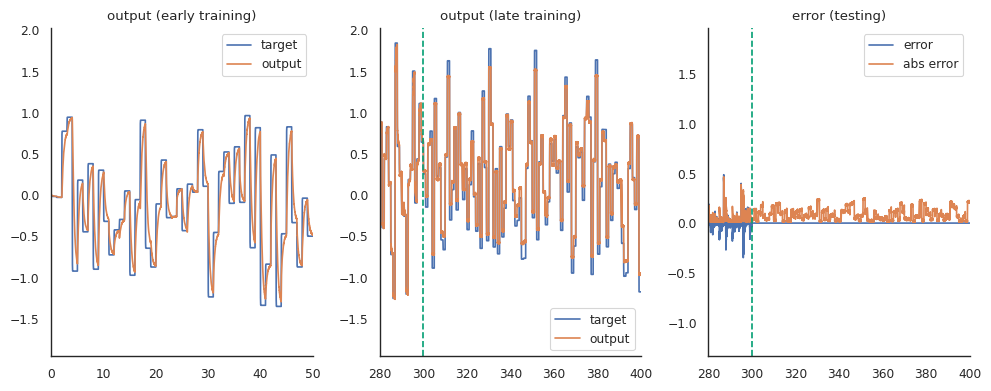

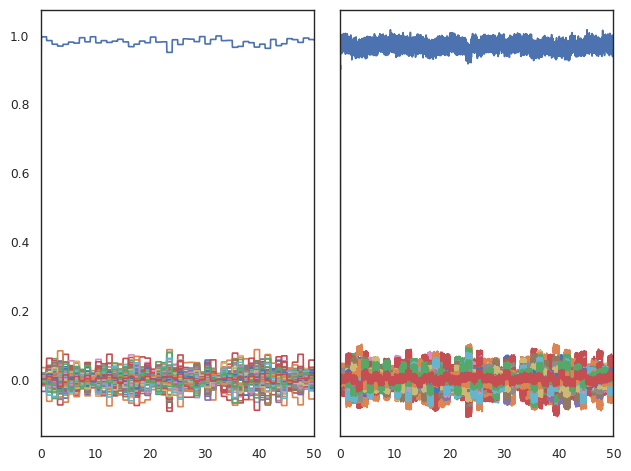

In [733]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(10,4))
axes[0].plot(sim.trange(), sim.data[p_target], label='target')
axes[0].plot(sim.trange(), sim.data[p_output], label='output')
axes[1].plot(sim.trange(), sim.data[p_target], label='target')
axes[1].plot(sim.trange(), sim.data[p_output], label='output')
axes[2].plot(sim.trange(), sim.data[p_error], label='error')
axes[2].plot(sim.trange(), sim.data[p_reward], label='abs error')
axes[1].axvline(E, color=palette[2], linestyle='--')
axes[2].axvline(E, color=palette[2], linestyle='--')
axes[0].set(title='output (early training)', xlim=[0, 50*P])
axes[1].set(title='output (late training)', xlim=[E-20*P,T])
axes[2].set(title='error (testing)', xlim=[E-20*P,T])
axes[0].legend()
axes[1].legend()
axes[2].legend()
sns.despine()
plt.tight_layout()

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
axes[0].plot(sim.trange(), sim.data[p_ssp])
axes[1].plot(sim.trange(), sim.data[p_state])
axes[0].set(xlim=[0,50*P])
plt.tight_layout()

# Train and test multiple subjects

In [8]:
def train_test_subject(
    seed,
    P=1,  # trial time
    nT=400,  # total trials
    nE=300,  # training trials
    ssp_dim = 64,
    length_scale = 10,
    ssp_neurons = 300,
    error_neurons = 300,
    learning_rate = 3e-5,
    sigma_target = 1e-1,
):

    np.random.seed(seed)
    rng = np.random.RandomState(seed=seed)

    T = nT*P  # total time
    E = nE*P  # training time

    # Initialize SSP space
    ssp_space = sspspace.RandomSSPSpace(ssp_dim=ssp_dim, domain_dim=3, rng=rng)
    ssp_space.update_lengthscale([length_scale, length_scale, length_scale])
    
    # dynamic input to the network
    value_func = lambda x: x[0] + 0.5*x[1] - 0.5*x[2]
    objects = []
    values = []
    noises = []
    for trial in range(int(T/P)):
        features = rng.uniform(-1,1,size=3)
        object_ssp = ssp_space.encode(features)
        objects.append(object_ssp)
        value = value_func(features)
        values.append(value)
        noise = rng.uniform(0, sigma_target)
        noises.append(noise if trial < E/P else 0)  # remove noise during testing:
    
    # dynamic input to the network
    input_func = lambda t: objects[int(t/P)].flatten()
    target_func = lambda t: values[int(t/P)].flatten() + noises[int(t/P)]
    
    # error-driven learning rule
    pes = nengo.PES(learning_rate=learning_rate)
    
    # define and build the network
    network = nengo_spa.Network(seed=seed)
    with network:
        inpt_ssp = nengo.Node(input_func)
        inpt_target = nengo.Node(target_func)
        state = nengo_spa.State(ssp_dim, subdimensions=4, neurons_per_dimension=ssp_neurons)
        output = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
        target = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
        error = nengo.Ensemble(n_neurons=error_neurons, dimensions=1)
        temp = nengo.Ensemble(1, dimensions=2, neuron_type=nengo.Direct())
        reward = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.Direct())
        stop = nengo.Node(lambda t: -1000 if t>E else 0)
        
        # nengo.Connection(inpt_ssp, state, synapse=None)
        nengo.Connection(inpt_ssp, state.input, synapse=None)
        nengo.Connection(inpt_target, target, synapse=0.01)
        learning_conns = []
        learning_conns.append(nengo.Connection(state.state_ensembles.first, output, synapse=0.01, function=lambda x: 0, learning_rule_type=pes))
        learning_conns.append(nengo.Connection(state.state_ensembles.second, output, synapse=0.01, function=lambda x: 0, learning_rule_type=pes))
        for ens in state.state_ensembles.remainder.ea_ensembles:
            learning_conns.append(nengo.Connection(ens, output, synapse=0.01, function=lambda x: 0, learning_rule_type=pes))
        nengo.Connection(output, error, synapse=None, transform=-1)
        nengo.Connection(target, error, synapse=None, transform=1)
        for ens in learning_conns:
            nengo.Connection(error, ens.learning_rule, synapse=None, transform=-1)
        nengo.Connection(stop, error.neurons, transform=np.ones((error_neurons, 1)), synapse=None)
        nengo.Connection(output, temp[0], synapse=None)
        nengo.Connection(target, temp[1], synapse=None)
        nengo.Connection(temp, reward, synapse=None, function=lambda x: np.abs(x[0]-x[1]))
    
        p_ssp = nengo.Probe(inpt_ssp, synapse=0.01)
        p_state = nengo.Probe(state.output, synapse=0.01)
        p_output = nengo.Probe(output, synapse=0.01)
        p_target = nengo.Probe(target, synapse=0.01)
        p_error = nengo.Probe(error, synapse=0.01)
        p_reward = nengo.Probe(reward, synapse=0.01)
    
    sim = nengo.Simulator(network, progress_bar=False)
    with sim:
        sim.run(T-0.001)

    dfs = []
    columns = ['subject', 'error', 'trial', 'phase']
    for trial in range(nE):  # training 
        error = sim.data[p_reward][int(trial*P/0.001)][0]
        dfs.append(pd.DataFrame([[seed, error, trial, 'train']], columns=columns))
    for trial in range(nE, nT):  # testing
        error = sim.data[p_reward][int(trial*P/0.001)][0]
        dfs.append(pd.DataFrame([[seed, error, trial, 'test']], columns=columns))

    data = pd.concat(dfs, ignore_index=True)
    return data

In [9]:
def run_and_plot_subjects(subjects, **kwargs):
    dfs = []
    s = time.time()
    for seed in range(subjects):
        print(f'training subject {seed}')
        dfs.append(train_test_subject(seed=seed, **kwargs))
    data = pd.concat(dfs, ignore_index=True)
    e = time.time()
    print(f"runtime: {(e-s)/60:.2} minutes")

    mean_error = data.query("phase=='test'")['error'].mean()

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 3))
    sns.lineplot(data.query("phase=='train'"), x='trial', y='error', ax=axes[0], color=palette[0])
    sns.violinplot(data.query("phase=='test'"),  y='error', ax=axes[1], color=palette[0], label=f'mean error: {mean_error:.3}')
    # sns.boxplot(data.query("phase=='test'"),  y='error', ax=axes[1])
    # sns.barplot(data.query("phase=='test'"),  y='error', ax=axes[1], label=f'mean error: {mean_error:.3}')
    axes[0].set(title='training', ylim=[0,0.4])
    axes[1].set(title='testing')

training subject 0
training subject 1
runtime: 1.1 minutes


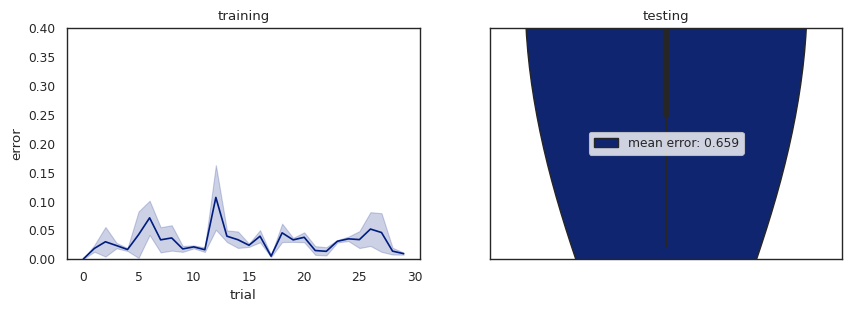

In [10]:
run_and_plot_subjects(2, nE=30, nT=40)

training subject 0
training subject 1
training subject 2
training subject 3
training subject 4
training subject 5
training subject 6
training subject 7
training subject 8
training subject 9
training subject 10
training subject 11
training subject 12
training subject 13
training subject 14
training subject 15
training subject 16
training subject 17
training subject 18
training subject 19
training subject 20
training subject 21
training subject 22
training subject 23
training subject 24
training subject 25
training subject 26
training subject 27
training subject 28
training subject 29
runtime: 4.1e+01 minutes


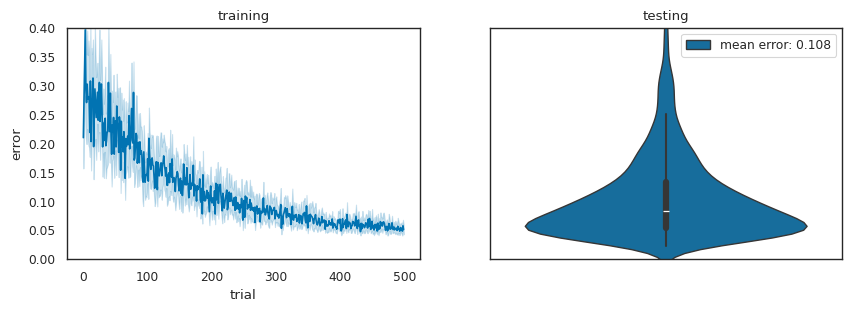

In [673]:
run_and_plot_subjects(3)